# Problem Set 3: Merging and regular expressions

**Total points (without extra credit)**: 44

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset3_inputdata` (need to unzip): 

- `jobs`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


## Resources from class

- [Lecture](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/06_qss20_w23_mergereshape.pdf) and [activity](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/03_reshaping_merging_solutions.ipynb) on exact merging
- [Lecture](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/07_qss20_w23_regex.pdf) and [activity](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/04_regex_blank.ipynb) on regular expressions (both coming in class on Feb. 1)
- DataCamp modules on both of these

# 0. Load packages & data (1 point total)

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 0.1 Load data (0 points)

Load the following dataset stored in `pset3_inputdata`&mdash;`debar.csv`&mdash;storing it as a dataframe named `debar`. This represents employers temporarily banned from hiring workers.

View the `head()` and columns of this dataframe.

In [2]:
## your code here
debar = pd.read_csv("pset3_inputdata/debar.csv", low_memory=False)

debar

,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
...,...,...,...,...,...,...
109,Dove Creek Farms,"Mount Vernon, TX",Failure to Respond to Audit Request,2 years,2/9/2018,2/8/2020
110,Jesus Ledesma,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20
111,Turner Farms,"Healy, KS",Failure to comply with the employer's obligati...,7 months,7/17/19,2/10/20
112,B & R Harvesting and Paul Cruz (individual),"Collins, Georgia",WHD Debarment,3 years,4/9/17,4/9/20


The most notable column names mean as follows:
- `Name`:	Company name of agricultural employer
- `City, State`:	City and state where employer located
- `Violation`:	Type of program violation
- `Start date`:	Start date of debarment (temporary ban)

## 0.2 Inspect data (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [3]:
# Number of rows in the dataframe
rows = debar.shape[0]

# Number of unique employer names (Name)
unique_names = debar['Name'].nunique()

print(f"Number of rows: {rows}")
print(f"Number of unique names: {unique_names}")
"There are multiple rows for each employer name."


Number of rows: 114
Number of unique names: 98


'There are multiple rows for each employer name.'

# 1. Reshape data and check duplicates (19 points total)

## 1.1 Make indicator for violation number (2 points)

To make it possible to reshape data, make an indicator for the violation number for each business. The indicator should take the value of `viol` if it's the first row/potential violation, `viol2` if the second row/potential violation, etc.

**Hint:**
- One way to do this is by using an if-else statement to check whether the business name is the same as in the row above (assuming rows are ordered by name). Grouping by employer name and checking the number of unique offenses would also work.

In [4]:
## your code here

# sort dataset alphabetically by name col
debar_sorted = debar.sort_values("Name",ascending=True).reset_index()

# initialize violation column
debar_sorted['violation'] = 1        
        
for i in range(len(debar_sorted)):
    if i > 0 and debar_sorted.loc[i, "Name"] == debar_sorted.loc[i-1, "Name"]:
        debar_sorted.loc[i, "violation"] = debar_sorted.loc[i-1, "violation"] + 1
        
debar_sorted[debar_sorted["violation"] > 1]
debar_sorted[debar_sorted["violation"] > 1].shape

,index,Name,"City, State",Violation,Duration,Start date,End date,violation
8,6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,2
11,29,Autumn Hill Orchard,"Groton, MA",Impeding the Audit Process – Non- Response,2 years,7/6/2014,7/5/2016,2
16,8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,2
20,56,Cisco Produce Inc.,"Cairo, GA",Impeding the Audit Process – Non- Response,2 years,12/10/2015,12/9/2017,2
31,103,Dove Creek Farms,"Mount Vernon, TX",Failure to respond to audit request,2 years,2/9/2018,2/8/2018,2
35,18,F&W Farms,"Ingalls, KS",Failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016,2
61,11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,2
65,55,Macky and Brad Farms,"Plains, TX",Impeding the Audit Process – Partial- Response,1 year,2/13/2015,2/12/2016,2
67,17,"Maple Ridge Custom Services, LLC","Altheimer, AK",Failure to respond to audit (partial response),2 years,11/16/2014,11/15/2016,2
69,60,Mark Duncan,"Roosevelt, UT",Impeding the Audit Process – Non- Response,2 years,11/16/2014,11/15/2016,2


(16, 8)

## 1.2 Clean up state names (3 points)

Inspect the state names in the business violation data. Which states have names sometimes indicated in long format vs. two-letter abbreviation, e.g. "New Hampshire" vs. "NH"? Which of these may have more than one violation?

**Hint:** 
- One way to do this is to extract state names from the `City, State` column using regex and/or string methods.
- The simplest way to check if a state may have more than one violation is to check how many times they appear using `value_counts()`. 

In [5]:
import re
## Regex to find one or two words after a comma and space
regex = ',\s(\w+\s?)+'

city_state = (debar_sorted['City, State'].tolist())
city_state_string = ""
for city_state in city_state:
    # Deal with nan values
    if (type(city_state) != str):
        city_state = ", nan"
    city_state_string += str(city_state) + "; "

states = re.findall(regex, city_state_string)
print(set(states))
"We see there are many states that use different abbreviations, such as 'Texas' and 'TX', or 'Florida' and 'FL'."

debar_sorted["State"] = states
debar_sorted
"[City, State] and [State] match up."

"Here are the number of violations per state:"
debar_sorted["State"].value_counts()


{'FL', 'ID', 'KS', 'Dakota', 'Massachusetts', 'Carolina', 'Arkansas', 'MA', 'TX', 'KY', 'NY', 'MD', 'SD', 'AK', 'IL', 'GA', 'Texas', 'MN', 'ND', 'CA', 'OK', 'SC', 'Florida', 'UT', 'MT', 'Kansas', 'ME', 'Utah', 'LA', 'CO', 'Idaho', 'California', 'Tennessee', 'Vermont', 'AR', 'Louisiana', 'nan', 'Georgia'}


"We see there are many states that use different abbreviations, such as 'Texas' and 'TX', or 'Florida' and 'FL'."

,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State
0,94,69 Farms LLC,"Preston, Idaho",Failure to respond to audit request,2 years,9/24/2016,9/23/2018,1,Idaho
1,97,AB Ranch,"Stephenville, Texas",Failure to respond to audit request,2 years,4/28/2017,4/27/2019,1,Texas
2,102,Abe- Nancy Froese,"Seminole, TX",Failure to respond to audit request,2 years,11/23/2017,11/23/2019,1,TX
3,36,Agecy I LLC,"Idabel, OK",Impeding the Audit Process – Non- Response,2 years,8/27/2015,8/26/2017,1,OK
4,53,"Agecy II, LLC","Ipswich, SD",Impeding the Audit Process – Non- Response,2 years,3/25/2015,3/24/2017,1,SD
...,...,...,...,...,...,...,...,...,...
109,73,Xavier Horne,"Lyons, Georgia",Non-payment of certification fee,1 year,6/16/2016,6/15/2017,1,Georgia
110,89,Xavier Horne,"Lyons, Georgia",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,2,Georgia
111,88,Yesenia Perez,"Axson, Georgia",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,1,Georgia
112,9,Yolanda Chavez,"Santa Maria, CA",Non Payment,1 year,7/23/2014,7/22/2015,1,CA


'[City, State] and [State] match up.'

'Here are the number of violations per state:'

TX               14
GA               10
Georgia           9
KS                9
FL                8
KY                5
SD                5
UT                4
Texas             4
CA                3
Dakota            3
CO                3
NY                3
ND                3
MT                2
LA                2
MA                2
Florida           2
Utah              2
AR                2
OK                2
ID                1
nan               1
Vermont           1
Kansas            1
Arkansas          1
AK                1
Idaho             1
Carolina          1
MD                1
Tennessee         1
MN                1
California        1
SC                1
Massachusetts     1
ME                1
Louisiana         1
IL                1
Name: State, dtype: int64

To make the state names consistent with the jobs data below, convert any discrepant state names to the two-letter abbreviation format. 

**Hints:**
- You could do this for all state names (to be safe) or only those you just identified. 
- If you want to change ANY discrepant state names from long format to two-letter format (i.e., a complete conversion), you can load state names from a complete name/abbreviation crosswalk and use that to change state names. Here is code to load in such a list ([from this blog](https://towardsdatascience.com/state-name-to-state-abbreviation-crosswalks-6936250976c)):
```python
crosswalk_url = 'http://app02.clerk.org/menu/ccis/Help/CCIS%20Codes/state_codes.html'
pd.read_html(crosswalk_url)[0]
```

In [6]:
## your code here

crosswalk_url = 'http://app02.clerk.org/menu/ccis/Help/CCIS%20Codes/state_codes.html'
state_names = pd.read_html(crosswalk_url)[0]
state_names_full = state_names["Description"].tolist()
state_names_code = state_names["Code"].tolist()

for state_name in state_names_full:
   debar_sorted.loc[debar_sorted["State"].str.contains(state_name), "City, State"] = debar_sorted.loc[debar_sorted["State"].str.contains(state_name), "City, State"].str.replace(state_name, state_names_code[state_names_full.index(state_name)])
   debar_sorted.loc[debar_sorted["State"].str.contains(state_name), "State"] = state_names_code[state_names_full.index(state_name)]
    
debar_sorted

/var/folders/1y/tx5xv7mx325cz5z1q7xc35sm0000gn/T/ipykernel_20393/3428352579.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  debar_sorted.loc[debar_sorted["State"].str.contains(state_name), "City, State"] = debar_sorted.loc[debar_sorted["State"].str.contains(state_name), "City, State"].str.replace(state_name, state_names_code[state_names_full.index(state_name)])
/var/folders/1y/tx5xv7mx325cz5z1q7xc35sm0000gn/T/ipykernel_20393/3428352579.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  debar_sorted.loc[debar_sorted["State"].str.contains(state_name), "City, State"] = debar_sorted.loc[debar_sorted["State"].str.contains(state_name), "City, State"].str.replace(state_name, state_names_code[state_names_full.index(state_name)])
/var/folders/1y/tx5xv7mx325cz5z1q7xc35sm0000gn/T/ipykernel_20393/3428352579.py:10: UserWarning: This pattern is interpreted a

,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State
0,94,69 Farms LLC,"Preston, ID",Failure to respond to audit request,2 years,9/24/2016,9/23/2018,1,ID
1,97,AB Ranch,"Stephenville, TX",Failure to respond to audit request,2 years,4/28/2017,4/27/2019,1,TX
2,102,Abe- Nancy Froese,"Seminole, TX",Failure to respond to audit request,2 years,11/23/2017,11/23/2019,1,TX
3,36,Agecy I LLC,"Idabel, OK",Impeding the Audit Process – Non- Response,2 years,8/27/2015,8/26/2017,1,OK
4,53,"Agecy II, LLC","Ipswich, SD",Impeding the Audit Process – Non- Response,2 years,3/25/2015,3/24/2017,1,SD
...,...,...,...,...,...,...,...,...,...
109,73,Xavier Horne,"Lyons, GA",Non-payment of certification fee,1 year,6/16/2016,6/15/2017,1,GA
110,89,Xavier Horne,"Lyons, GA",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,2,GA
111,88,Yesenia Perez,"Axson, GA",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,1,GA
112,9,Yolanda Chavez,"Santa Maria, CA",Non Payment,1 year,7/23/2014,7/22/2015,1,CA


## 1.3 Investigate duplicated rows (4 points)

A. Create a new column in `debar`, `is_repeated`, that tells us whether an employer (`Name`) is repeated > 1 times.

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using `value_counts()` on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret with at least a sentence. If you notice any cases of duplicate business names where 'City, State' does NOT match exactly, check these manually and make them consistent.

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [7]:
## your code here

#A.
# get all Names that appeared more than once into a list-set
debar_sorted['is_repeated'] = debar_sorted['Name'].duplicated(keep=False)

#B.
debar_sorted[debar_sorted['is_repeated'] == True]
"We see there are 32 duplicates, so 16 business committed multiple violations. This matches up with the number of rows where the column for violation is greater than 2, so the most violations any given business committed is 2." 
# manual change duplicates
### This says 'Brownsville, TX', but a google search of "Loewen Harvesting, Texas" business shows it's registered in Brownfield, TX
debar_sorted.loc[61, 'City, State'] = 'Brownfield, TX'
### This says AK, but a google search of "Maple Ridge Custom Services, Altheimer" business shows it's in AR
debar_sorted.loc[67, 'City, State'] = 'Altheimer, AR'

#C.
# create mult_debar
mult_debar = debar_sorted[debar_sorted['is_repeated'] == True].copy()
mult_debar.head()
mult_debar.shape

,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State,is_repeated
7,30,Annabella Land & Cattle,"Annabella, UT",Non-payment,1 year,5/9/2014,5/8/2015,1,UT,True
8,6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,2,UT,True
10,7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,1,MA,True
11,29,Autumn Hill Orchard,"Groton, MA",Impeding the Audit Process – Non- Response,2 years,7/6/2014,7/5/2016,2,MA,True
15,28,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Impeding the Audit Process – Partial- Response,2 years,7/20/2014,7/19/2016,1,TX,True
16,8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,2,TX,True
19,19,Cisco Produce Inc.,"Cairo, GA",Failure to respond to audit (no response),2 years,12/10/2014,12/9/2016,1,GA,True
20,56,Cisco Produce Inc.,"Cairo, GA",Impeding the Audit Process – Non- Response,2 years,12/10/2015,12/9/2017,2,GA,True
30,109,Dove Creek Farms,"Mount Vernon, TX",Failure to Respond to Audit Request,2 years,2/9/2018,2/8/2020,1,TX,True
31,103,Dove Creek Farms,"Mount Vernon, TX",Failure to respond to audit request,2 years,2/9/2018,2/8/2018,2,TX,True


'We see there are 32 duplicates, so 16 business committed multiple violations. This matches up with the number of rows where the column for violation is greater than 2, so the most violations any given business committed is 2.'

,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State,is_repeated
7,30,Annabella Land & Cattle,"Annabella, UT",Non-payment,1 year,5/9/2014,5/8/2015,1,UT,True
8,6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,2,UT,True
10,7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,1,MA,True
11,29,Autumn Hill Orchard,"Groton, MA",Impeding the Audit Process – Non- Response,2 years,7/6/2014,7/5/2016,2,MA,True
15,28,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Impeding the Audit Process – Partial- Response,2 years,7/20/2014,7/19/2016,1,TX,True


(32, 10)

## 1.4 Reshape `mult_debar` to wide format to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in these data: e.g., converting `Violation` to lowercase or replacing spelled-out states with two-dig state codes.

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

For a successful reshaping, make sure each row in `mult_debar` shows only a single business (no duplicates under `Name`) and isn't missing either `start_date_viol1` or `start_date_viol2`.

Show the contents of `mult_debar` and its shape.

In [8]:
## your code here

# mult_debar_wide = mult_debar.pivot(index=['Name', 'City, State'], columns='Violation', values='Start date')
mult_debar_wide = mult_debar.pivot(
                                   index=['Name', 'City, State'],
                                   columns='violation',
                                   values=['Start date']
                                  )

mult_debar_wide.columns = ['start_date_viol1', 'start_date_viol2']
mult_debar_wide
mult_debar_wide.shape

,,start_date_viol1,start_date_viol2
Name,"City, State",,
Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015
Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018
F&W Farms,"Ingalls, KS",12/10/2014,12/10/2014
Loewen Harvesting LLC,"Brownfield, TX",8/20/2014,8/20/2014
Macky and Brad Farms,"Plains, TX",2/13/2015,2/13/2015
"Maple Ridge Custom Services, LLC","Altheimer, AR",11/16/2014,11/16/2014


(16, 2)

## 1.5 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning, `debar`, filter as follows:
- For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
- For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
- Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [9]:
## your code here
mult_debar_wide['is_dup'] = np.where(mult_debar_wide['start_date_viol1'] == mult_debar_wide['start_date_viol2'], True, False)
mult_debar_wide[mult_debar_wide['is_dup'] == True].shape
"We see that we have 13 duplicates, so there should only be 3 cases where businesses actually committed 2 violations."

# iterate through dataframe
for index, row in mult_debar_wide.iterrows():  
    if (row["is_dup"] == True):
        debar_sorted = debar_sorted.drop(debar_sorted[(debar_sorted['Name'] == index[0]) & (debar_sorted['violation'] == 2)].index)
        
debar_clean = debar_sorted.drop("is_repeated", axis=1)
debar_clean[debar_clean["violation"] > 1]
"These are the three actual cases where businesses committed their second violation."

debar_sorted.shape
debar_sorted.agg({'Name': ['count', 'nunique']})

(13, 3)

'We see that we have 13 duplicates, so there should only be 3 cases where businesses actually committed 2 violations.'

,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State
20,56,Cisco Produce Inc.,"Cairo, GA",Impeding the Audit Process – Non- Response,2 years,12/10/2015,12/9/2017,2,GA
75,51,Old Tree Farms/Verpaalen Custom Service,"Volga, SD",Wage Hour Debarment,3 years,12/1/2014,12/1/2017,2,SD
110,89,Xavier Horne,"Lyons, GA",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,2,GA


'These are the three actual cases where businesses committed their second violation.'

(101, 10)

,Name
count,101
nunique,98


# 2. Merging and regex (19 points total)



## 2.1 Load data on job postings (1 point)

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations. Since most of the bans have expired, let's see which of those employers posted new H-2A jobs in the first quarter of 2021.

First, load the `jobs.csv` data stored in `pset3_inputdata`.

In [10]:
# your code here to load the data 
jobs = pd.read_csv("pset3_inputdata/jobs.csv", low_memory=False)
jobs

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"Fazio Farms Operating Company, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,Charlie Sunderland,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Michael Rudebusch,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Lodahl Farms,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"Dunson Harvesting, Inc.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,H-300-20351-963307,Determination Issued - Certification,2020-12-17 10:34:09.530,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,James L Schneller,NaN,...,N,1,N,NaN,12.68,55.0,12709914373,jims4463@aol.com,NaN,0
2716,H-300-20351-963399,Determination Issued - Certification,2020-12-17 14:37:57.920,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,Stephen G Myers,NaN,...,N,1,N,NaN,12.68,55.0,12708780028,vjpm76@gmail.com,https://kentucky.gov/employment/Pages/default....,1
2717,H-300-20351-964097,Determination Issued - Certification,2020-12-22 12:21:32.370,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,Andy Povey,Andy Povey Farms,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0
2718,H-300-20351-965435,Determination Issued - Certification,2020-12-22 12:18:43.280,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,"Silver Creek Seed, LLC",NaN,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0


The most notable column names mean as follows:
- `CASE_NUMBER`:	Administrative identifier for an employer's H-2A visa application
- `EMPLOYER_NAME`:	Employer name
- `EMPLOYER_CITY`:	Employer city
- `EMPLOYER_STATE`:	Employer state
- `EMPLOYER_ADDRESS_1`:	Employer address (only need to use if doing the geocoding extra credit)

##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [11]:
## your code here
merged_by_name = pd.merge(jobs, debar_clean, left_on='EMPLOYER_NAME', right_on='Name', how='inner')
merged_by_name
"We see there is only one exact match."

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,TOTAL_ADDENDUM_A_RECORDS,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,Rafael Barajas,NaN,...,7,63,Rafael Barajas,"Sebring, FL",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,1,FL


'We see there is only one exact match.'

## 2.3 Targeted regex (11 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Convert to upper (3 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [12]:
# ## insert your code to turn into uppercase here
debar_name_upper = [name.upper() for name in debar_clean['Name']]
job_employer_name_upper = [name.upper() for name in jobs['EMPLOYER_NAME']]


In [13]:
## insert your code for the random sample
print(random.choices(debar_name_upper, k=15))
print(random.choices(job_employer_name_upper, k=15))

['C HANGING L RANCH LLP', 'PETER PETERS', 'GERMAN FARMS', 'LABATTE FARMS', 'DEAL FAMILY FARM', 'AGECY II, LLC', 'JESUS LEDESMA', 'MACKY AND BRAD FARMS', 'YOLANDA CHAVEZ', 'JOHN R. COOK', 'HAITI/USA WORKFORCE, LLC', 'F&W FARMS', 'YOLANDA CHAVEZ', 'SLASH E.V. RANCH LLP', 'ALTERIC JEAN-CHARLES']
['ROUGE RIVER FARMS, INC.  ', 'STAR RANCH OF OZONA, LLC', 'FARM OP KUZZENS H2A, LLC', 'WESTERN RANGE ASSOCIATION', 'TITAN PEACH FARMS, INC. ', 'ST. JOE VALLEY APIARIES', 'WALLA WALLA NURSERY COMPANY INC.', 'SOWELL ORCHARDS FRUIT AND SALES', 'ARIZONA APIARIES LLC', 'BEECH CREEK FARMS, LLC', 'DOMINGUEZ CANYON FRUIT COMPANY', 'JOHN UHALDE AND CO. ', 'NICHOLAS P. VONDENSTEIN', 'BONK FARMS LLC', 'FOOTHILL PACKING, INC.']


In [14]:
## insert your code for assigning the uppercase names back to the data
debar_clean["Name"] = debar_name_upper
jobs["EMPLOYER_NAME"] = job_employer_name_upper

debar_clean
jobs
"'Name' & 'EMPLOYER_NAME' are now uppercase."

,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State
0,94,69 FARMS LLC,"Preston, ID",Failure to respond to audit request,2 years,9/24/2016,9/23/2018,1,ID
1,97,AB RANCH,"Stephenville, TX",Failure to respond to audit request,2 years,4/28/2017,4/27/2019,1,TX
2,102,ABE- NANCY FROESE,"Seminole, TX",Failure to respond to audit request,2 years,11/23/2017,11/23/2019,1,TX
3,36,AGECY I LLC,"Idabel, OK",Impeding the Audit Process – Non- Response,2 years,8/27/2015,8/26/2017,1,OK
4,53,"AGECY II, LLC","Ipswich, SD",Impeding the Audit Process – Non- Response,2 years,3/25/2015,3/24/2017,1,SD
...,...,...,...,...,...,...,...,...,...
109,73,XAVIER HORNE,"Lyons, GA",Non-payment of certification fee,1 year,6/16/2016,6/15/2017,1,GA
110,89,XAVIER HORNE,"Lyons, GA",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,2,GA
111,88,YESENIA PEREZ,"Axson, GA",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,1,GA
112,9,YOLANDA CHAVEZ,"Santa Maria, CA",Non Payment,1 year,7/23/2014,7/22/2015,1,CA


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"FAZIO FARMS OPERATING COMPANY, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,CHARLIE SUNDERLAND,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,MICHAEL RUDEBUSCH,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,LODAHL FARMS,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"DUNSON HARVESTING, INC.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,H-300-20351-963307,Determination Issued - Certification,2020-12-17 10:34:09.530,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,JAMES L SCHNELLER,NaN,...,N,1,N,NaN,12.68,55.0,12709914373,jims4463@aol.com,NaN,0
2716,H-300-20351-963399,Determination Issued - Certification,2020-12-17 14:37:57.920,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,STEPHEN G MYERS,NaN,...,N,1,N,NaN,12.68,55.0,12708780028,vjpm76@gmail.com,https://kentucky.gov/employment/Pages/default....,1
2717,H-300-20351-964097,Determination Issued - Certification,2020-12-22 12:21:32.370,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,ANDY POVEY,Andy Povey Farms,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0
2718,H-300-20351-965435,Determination Issued - Certification,2020-12-22 12:18:43.280,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,"SILVER CREEK SEED, LLC",NaN,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0


"'Name' & 'EMPLOYER_NAME' are now uppercase."

### 2.3.2 Clean up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [15]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [16]:
## insert your code here with the regex pattern for part A
regex = r"(INC|LLC|CO)\."

## insert your code to use re.sub to apply the pattern to the test cases for part B
re.sub(regex, r"\1", pos_example_1)
re.sub(regex, r"\1", pos_example_2)
re.sub(regex, r"\1", neg_example)

'CISCO PRODUCE INC'

'AVOYELLES HONEY CO, LLC'

'E.V. RANCH LLP'

### 2.3.3 Clean employer names (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [17]:
## your code here to clean the columns
debar_clean["name_clean"] = [re.sub(regex, r"\1", name) for name in debar_clean["Name"].tolist()]
debar_clean[debar_clean["Name"] != debar_clean["name_clean"]][["Name", "name_clean"]]

,Name,name_clean
5,ALTENDORF TRANSPORT INC.,ALTENDORF TRANSPORT INC
9,ANTON FERTILIZER INC.,ANTON FERTILIZER INC
12,"AVOYELLES HONEY CO., LLC","AVOYELLES HONEY CO, LLC"
19,CISCO PRODUCE INC.,CISCO PRODUCE INC
20,CISCO PRODUCE INC.,CISCO PRODUCE INC
39,GERONIMO SHEEP CO.,GERONIMO SHEEP CO
42,"GREAT PLAINS FLUID SERVICE, INC.","GREAT PLAINS FLUID SERVICE, INC"
80,PROMAX INC.,PROMAX INC
85,REIMER'S INC.,REIMER'S INC
86,REIMER’S INC.,REIMER’S INC


In [18]:
## your code here to print the head
jobs["name_clean"] = [re.sub(regex, r"\1", name) for name in jobs["EMPLOYER_NAME"].tolist()]
jobs[jobs["EMPLOYER_NAME"] != jobs["name_clean"]][["EMPLOYER_NAME", "name_clean"]]

,EMPLOYER_NAME,name_clean
4,"DUNSON HARVESTING, INC.","DUNSON HARVESTING, INC"
7,"FARM LABOR ASSOCIATION FOR GROWERS, INC.","FARM LABOR ASSOCIATION FOR GROWERS, INC"
14,"MCLAIN FARMS, INC.","MCLAIN FARMS, INC"
17,"BONNIE PLANTS, INC.","BONNIE PLANTS, INC"
18,"B & W QUALITY GROWERS, INC.","B & W QUALITY GROWERS, INC"
...,...,...
2700,HARRAL LIVESTOCK CO. LLC,HARRAL LIVESTOCK CO LLC
2701,ECOSYSTEM CONCEPTS INC.,ECOSYSTEM CONCEPTS INC
2702,SIDDOWAY SHEEP CO.,SIDDOWAY SHEEP CO
2705,SATHER MANAGEMENT INC.,SATHER MANAGEMENT INC


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe. Write a sentence describing how name cleaning affected the match results.

**Note**: this manual cleaning process is inefficient and may miss other likely matches. A better approach would be fuzzy matching, which would recognize that 'Slash EV ranch' is a highly similar string to 'slash ev ranch llp' and match them without us needing to use regex to make the strings identical. We may talk about this in class later if time!

In [19]:
## your code here
# A.
merged_by_name_clean = pd.merge(jobs, debar_clean, on="name_clean", how="inner")
merged_by_name_clean
"Still only one exact match."

# Check:
# jobs[jobs["name_clean"].isin(debar_clean["name_clean"])][["EMPLOYER_NAME", "name_clean"]]

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,name_clean,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,RAFAEL BARAJAS,63,RAFAEL BARAJAS,"Sebring, FL",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,1,FL


'Still only one exact match.'

In [20]:
# B.
debar_clean[debar_clean["name_clean"] == "SLASH E.V. RANCH LLP"]

debar_clean["name_clean_2"] = [re.sub(r"\sE\.V\.\sRANCH\sLLP", " EV RANCH", name) for name in debar_clean["name_clean"].tolist()]

debar_clean[debar_clean["name_clean"] != debar_clean["name_clean_2"]][["name_clean", "name_clean_2"]]

,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State,name_clean
97,20,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,1,CO,SLASH E.V. RANCH LLP


,name_clean,name_clean_2
97,SLASH E.V. RANCH LLP,SLASH EV RANCH


In [21]:
#C.
merged_by_name_clean_jobs = pd.merge(jobs, debar_clean, left_on="name_clean", right_on="name_clean_2", how="left", suffixes=["_jobs", "_debar"], indicator=True)
merged_by_name_clean_jobs[merged_by_name_clean_jobs["_merge"] == "both"]

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,"City, State",Violation,Duration,Start date,End date,violation,State,name_clean_debar,name_clean_2,_merge
791,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,"Sebring, FL",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,1.0,FL,RAFAEL BARAJAS,RAFAEL BARAJAS,both
1115,H-300-20306-894148,Determination Issued - Certification,2020-11-02 18:11:29.140,2020-11-24 00:00:00.000,Individual Employer,N,Seasonal,N,SLASH EV RANCH,NaN,...,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,1.0,CO,SLASH E.V. RANCH LLP,SLASH EV RANCH,both


We can see our cleanup for `SLASH EV RANCH` worked, as it was merged from `debar_clean` into `jobs` with a left merge. However, it was fairly labor intensive to run a regex on every name in `debar_clean` just for the sake of one more match, so I think this is an inefficient approach.

# 3. Regex to separate companies from individuals (6 points)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [22]:
# debar_clean[debar_clean['Name'].str.contains('(COMPANY)')]
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

## your code here to define the pattern
regex = r'(.*)\s\(COMPANY\)\sAND\s(.*)\s\(INDIVIDUAL\)'

## your code here to apply it to the pos_example
result = re.search(regex, pos_example)
print(result.group(1), ',', result.group(2))

## your code here to apply it to the negative example
result2 = re.search(regex, neg_example)
if result2:
    print(result2.group(1), ',', result2.group(2))
else:
    print(result2)

COUNTY FAIR FARM , ANDREW WILLIAMSON
None


C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [23]:
# your code here
debar_clean['co_name'] = 0
debar_clean['ind_name'] = 0

for index, row in debar_clean.iterrows():
    regex = r'(.*)\s\(COMPANY\)\sAND\s(.*)\s\(INDIVIDUAL\)'
    result = re.search(regex, row['name_clean'])

    if result:
        debar_clean.at[index, 'co_name'] = result.group(1)
        debar_clean.at[index, 'ind_name'] = result.group(2)
    else:
        debar_clean.at[index, 'co_name'] = row['name_clean']
        debar_clean.at[index, 'ind_name'] = row['name_clean']

debar_clean.head()

,index,Name,"City, State",Violation,Duration,Start date,End date,violation,State,name_clean,name_clean_2,co_name,ind_name
0,94,69 FARMS LLC,"Preston, ID",Failure to respond to audit request,2 years,9/24/2016,9/23/2018,1,ID,69 FARMS LLC,69 FARMS LLC,69 FARMS LLC,69 FARMS LLC
1,97,AB RANCH,"Stephenville, TX",Failure to respond to audit request,2 years,4/28/2017,4/27/2019,1,TX,AB RANCH,AB RANCH,AB RANCH,AB RANCH
2,102,ABE- NANCY FROESE,"Seminole, TX",Failure to respond to audit request,2 years,11/23/2017,11/23/2019,1,TX,ABE- NANCY FROESE,ABE- NANCY FROESE,ABE- NANCY FROESE,ABE- NANCY FROESE
3,36,AGECY I LLC,"Idabel, OK",Impeding the Audit Process – Non- Response,2 years,8/27/2015,8/26/2017,1,OK,AGECY I LLC,AGECY I LLC,AGECY I LLC,AGECY I LLC
4,53,"AGECY II, LLC","Ipswich, SD",Impeding the Audit Process – Non- Response,2 years,3/25/2015,3/24/2017,1,SD,"AGECY II, LLC","AGECY II, LLC","AGECY II, LLC","AGECY II, LLC"


   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [24]:
# your code here
debar_clean[debar_clean['Name'].str.contains('COUNTY FAIR FARM')][['name_clean', 'co_name', 'ind_name', 'Violation']]
debar_clean[debar_clean['Name'].str.contains('CISCO PRODUCE')][['name_clean', 'co_name', 'ind_name', 'Violation']]

,name_clean,co_name,ind_name,Violation
22,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON,WHD Debarment


,name_clean,co_name,ind_name,Violation
19,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Failure to respond to audit (no response)
20,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Impeding the Audit Process – Non- Response


# 4. Optional extra credit: Geospatial visualization (2 points)

Geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on a map of Georgia. This involves Googling and using external sources to figure out the code (a common practice in real-life data science), since we haven't spatial data in the course. 

**Hints:**
- Relevant columns include `EMPLOYER_ADDRESS_1` 
- The geocoding might have a long runtime, so feel free to implement it in a separate `.py` script that you submit alongside your notebook and to just read in the geocoded data

**Resources:**
- [Discussion of geocoding addresses -> lat/long](https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/)
- [Discussion of plotting lat/long dots against a map using geopandas](https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73)

,Unnamed: 0,address,geocoded
0,0,8433 NE 13th Ave,"(25.8751418, -80.1712)"
1,1,982 Northcutts Cove Road,"(35.592258, -85.7201458)"
2,2,7366 State Hwy 146 S,NaN
3,3,4198 Road 2049,"(48.2931316, -105.7670815)"
4,4,400 Eagle Lake Loop Rd.,"(27.9703764, -81.7346226)"


/opt/homebrew/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

<AxesSubplot: >

Text(0.5, 1.0, 'Georgia Business Locations')

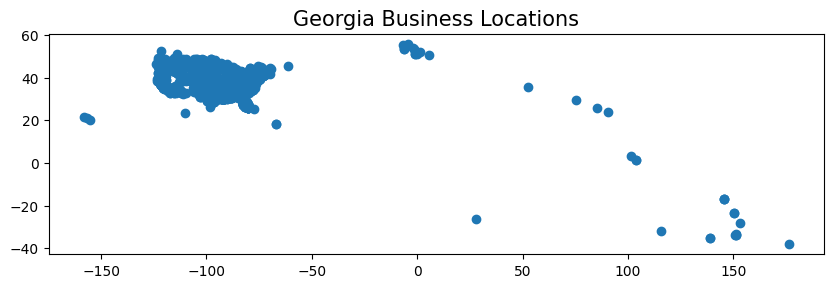

In [100]:
## your code here
import googlemaps as googlemaps
import geopandas as gpd
import config
cfg = config.Config("../../config.py")
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np

### Run first time:
# addresses = pd.DataFrame(jobs["EMPLOYER_ADDRESS_1"].drop_duplicates())
# addresses.rename(columns={"EMPLOYER_ADDRESS_1": "address"}, inplace=True)

# gmaps_key = googlemaps.Client(cfg['gmaps_key'])

# def geocode(address):
#     try: 
#         g = gmaps_key.geocode(address)
#         lat = g[0]["geometry"]["location"]["lat"]
#         lng = g[0]["geometry"]["location"]["lng"]
#         return (lat, lng)
#     # In case no lng/lat is found
#     except:
#         return None

# addresses['geocoded'] = [geocode(address) for address in addresses['address'].tolist()]
# addresses.to_csv("geocoded_addresses.csv")

addresses = pd.read_csv("geocoded_addresses.csv")
addresses.head()

def convert_to_point(x):
    if type(x) == str:
        x = x.replace("(", "").replace(")","").split(",")
        return Point(float(x[1]), float(x[0]))
    else:
        return None

geometry = addresses['geocoded'].apply(lambda x: convert_to_point(x) if x else None)

crs = {'init':'EPSG:4326'}
fig, ax = plt.subplots(figsize = (10,10))

geo_df = gpd.GeoDataFrame(addresses, crs=crs, geometry=geometry)

georgia_map = gpd.read_file("./Georgia_State_Boundary/Georgia_State_Boundary.shp")

georgia_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
# geo_df.plot(ax=ax)
ax.set_title('Georgia Business Locations', fontsize=15)


